In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import torch
from torch.utils.data import Dataset
import time
import datetime
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from torch import cuda 
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.optim import AdamW
from transformers import AutoTokenizer
torch.cuda.empty_cache()
device = 'cuda' if cuda.is_available() else 'cpu'
warnings.filterwarnings("ignore")
from modelling import *

In [14]:
data_class  = DataClass(use_prediction= True,use_enhanced=True,custom=False)
data_class.create_dataset()
modelling_data = DataModel(data = data_class.data_model,
                           custom_test_index=data_class.enhanced_index,
                           custom=False)
modelling_data.create_padding()
modelling_data.test

modifying features
['link', 'employer', 'occupation', 'name_sex', 'firstname_lower']
['link', 'employer', 'occupation', 'name_sex', 'firstname_lower_enhanced']
Shape of training tensor:  (162, 50)
Shape of testing tensor:  (70, 50)


,message,label
113,prenom femme marie,0
69,metages prenom homme floris,1
57,prenom femme juliette,0
218,Ch Labrye Menseuvr prenom homme jean,1
104,patron prenom femme gilberte,1
...,...,...
90,Crousiere entiiiateur prenom homme françois,1
117,sans pof prenom femme marie,0
217,prenom femme marceline,0
64,fille sp prenom femme léonie,0


In [15]:
class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=180, tokenizer_name='bert-base-uncased'):
        self.texts = dataframe['message'].values
        self.targets = dataframe['label'].values
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        return {
            'input_ids': torch.as_tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.as_tensor(attention_mask, dtype=torch.long),
            'targets': torch.as_tensor(target, dtype=torch.long),
            'text': text
        }
        
        
# Create custom Datasets
train_dataset = TextDataset(modelling_data.train)
test_dataset = TextDataset(modelling_data.test)

In [16]:
BATCH_SIZE = 10

In [17]:
torch.manual_seed(1702)
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=4)
next(iter(train_loader))

{'input_ids': tensor([[  101,  9161, 10722,  ...,     0,     0,     0],
         [  101,  1000,  1005,  ...,     0,     0,     0],
         [  101,  1999,  2546,  ...,     0,     0,     0],
         ...,
         [  101, 10026,  3653,  ...,     0,     0,     0],
         [  101,  8909,  8909,  ...,     0,     0,     0],
         [  101,  3653,  3630,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1]),
 'text': [' patron  Turaliste prenom homme gabriel',
  '  "\'  prenom femme jeanne',
  'inf    prenom homme joseph',
  'enfant    prenom homme jean',
  'camprof    prenom femme louise',
  'fille    prenom femme clémence',
  'id    prenom femme marthe',
  'chef    prenom homme pierre',
  'id  id  prenom homme jean',
  ' 

In [6]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [7]:
EPOCHS = 20

optimizer = AdamW(model.parameters(),
                  lr = 1e-4, 
                  eps = 1e-8)

In [8]:
training_stats = []
epoch_loss_train = []
total_t0 = time.time()

# TRAINING
for epoch in range(1, EPOCHS + 1):
    model.train()
    t0 = time.time()
    print("")
    print("================ Epoch {:} / {:} ================".format(epoch, EPOCHS))
    train_all_predictions = []
    train_all_true_labels = []
    for step, data in enumerate(train_loader):
        print(step)
        if step % 2 == 0 and not step == 0:
            elapsed = int(round(time.time() - t0))
            elapsed = str(datetime.timedelta(seconds=elapsed))
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_loader), elapsed
                )
            )
        
        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)

        model.zero_grad()

        loss, logits = model(
            ids, token_type_ids=None, attention_mask=mask, labels=targets
        ).to_tuple()
        epoch_loss_train.append(loss.item())

        cpu_logits = logits.cpu().detach().numpy()
        train_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
        train_all_true_labels.extend(targets.cpu().numpy())

        loss.backward()
        optimizer.step()
    train_accuracy = accuracy_score(train_all_true_labels, train_all_predictions)
    print(train_accuracy)
    training_stats.append(
            {
            'epoch': epoch,
            'Training Loss': np.mean(epoch_loss_train),
            'Training Accuracy': train_accuracy}
    )


================ Epoch 1 / 20 ================
0
1
2
  Batch     2  of     21.    Elapsed: 0:00:57.
3
4
  Batch     4  of     21.    Elapsed: 0:01:45.
5
6
  Batch     6  of     21.    Elapsed: 0:02:34.
7
8
  Batch     8  of     21.    Elapsed: 0:03:20.
9
10
  Batch    10  of     21.    Elapsed: 0:04:11.
11
12
  Batch    12  of     21.    Elapsed: 0:05:02.
13
14
  Batch    14  of     21.    Elapsed: 0:06:00.
15
16
  Batch    16  of     21.    Elapsed: 0:06:57.
17
18
  Batch    18  of     21.    Elapsed: 0:08:12.
19
20
  Batch    20  of     21.    Elapsed: 0:09:18.
0.848780487804878

================ Epoch 2 / 20 ================
0
1
2
  Batch     2  of     21.    Elapsed: 0:02:45.
3
4
  Batch     4  of     21.    Elapsed: 0:04:03.
5
6
  Batch     6  of     21.    Elapsed: 0:04:55.
7
8
  Batch     8  of     21.    Elapsed: 0:05:49.
9
10
  Batch    10  of     21.    Elapsed: 0:06:31.
11
12
  Batch    12  of     21.    Elapsed: 0:07:20.
13
14
  Batch    14  of     21.    Elapsed: 0:08:06.

In [9]:
# Define the path to save the model state dictionary
model_file_path = 'model/socface_model.pth'
model.save_pretrained(model_file_path)

## load the model and compute test results

In [10]:
# Load the model*
model_file_path = 'model/socface_model.pth'
model_trained = BertForSequenceClassification.from_pretrained(model_file_path)
model_trained.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
test_all_predictions = []
test_all_true_labels = []
model_trained.eval()
epoch_loss_test = []
test_all_predictions = []
test_all_true_labels = []
s = 0
for data in test_loader:
    s += 1
    print(s)
    if s <= 1000 : 
        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)
        with torch.no_grad():
            loss, logits = model_trained(ids, token_type_ids=None, attention_mask=mask, labels=targets).to_tuple()
                
            epoch_loss_test.append(loss.item())
            cpu_logits = logits.cpu().detach().numpy()
            test_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
            test_all_true_labels.extend(targets.cpu().numpy())
    else :
        print('done')
        break
test_accuracy = accuracy_score(test_all_true_labels, test_all_predictions)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


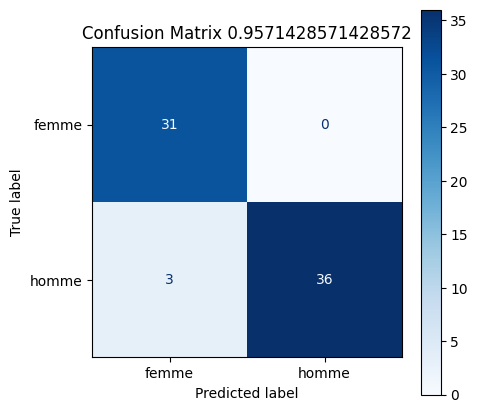

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_all_true_labels, test_all_predictions, labels=[0,1])
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['femme','homme'])
disp.plot(values_format='d', cmap='Blues', ax=ax)
plt.title(f'Confusion Matrix {test_accuracy}')
plt.show()